# 🚀 15-Minute Forex Prediction Model Training

**Model:** Transformer + LSTM Hybrid  
**Horizon:** 15 minutes  
**Target Accuracy:** 88-92%

---


## 📦 1. Imports & Setup


In [92]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Custom modules
from backend.ml.preprocessing.data_loader import ForexDataLoader, create_labels
from backend.ml.preprocessing.sequence_generator import SequenceGenerator, split_train_val_test
from backend.ml.features.technical_indicators import calculate_all_features, get_feature_columns
from backend.ml.models.transformer_lstm import build_transformer_lstm_model, compile_model

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU available: {tf.config.list_physical_devices('GPU')}")

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

✅ TensorFlow version: 2.20.0
✅ GPU available: []


## 📥 2. Load Pre-calculated Features

Loading **EUR_USD_features.csv** from 02_Feature_Engineering notebook


In [93]:
# Load pre-calculated features
features_file = Path('../data/processed/EUR_USD_features.csv')

print(f"📥 Loading features from: {features_file}")
print(f"   File exists: {features_file.exists()}")

if features_file.exists():
    print(f"   File size: {features_file.stat().st_size / (1024*1024):.2f} MB\n")
    
    # Load with datetime index
    df_features = pd.read_csv(features_file, index_col=0, parse_dates=True)
    
    print(f"✅ Features loaded!")
    print(f"  Shape: {df_features.shape}")
    print(f"  Date range: {df_features.index.min()} to {df_features.index.max()}")
    print(f"  Columns: {len(df_features.columns)} total")
    print(f"\n🔍 First 5 rows:")
    display(df_features.head())
else:
    print("\n❌ Feature file not found!")
    print("   Please run 02_Feature_Engineering.ipynb first.")

📥 Loading features from: ..\data\processed\EUR_USD_features.csv
   File exists: True
   File size: 148.21 MB

✅ Features loaded!
  Shape: (199801, 44)
  Date range: 2019-12-31 19:19:00+00:00 to 2020-07-14 20:02:00+00:00
  Columns: 44 total

🔍 First 5 rows:
✅ Features loaded!
  Shape: (199801, 44)
  Date range: 2019-12-31 19:19:00+00:00 to 2020-07-14 20:02:00+00:00
  Columns: 44 total

🔍 First 5 rows:


,open,high,low,close,volume,tick_volume,returns,log_returns,price_range,price_volatility,...,bb_upper_50,bb_lower_50,bb_width_50,atr_14,stoch_k,stoch_d,adx,volume_sma_20,volume_ratio,obv
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:19:00+00:00,1.12212,1.12212,1.12204,1.12205,95.15,95.15,-0.000053,-0.000053,0.00008,0.000055,...,1.122596,1.122068,0.046980,0.000076,15.789474,17.543860,27.223107,60.6660,1.568424,1248.67
2019-12-31 19:20:00+00:00,1.12206,1.12207,1.12201,1.12201,59.63,59.63,-0.000036,-0.000036,0.00006,0.000054,...,1.122601,1.122046,0.049420,0.000075,5.263158,17.543860,27.433872,60.4995,0.985628,1189.04
2019-12-31 19:21:00+00:00,1.12200,1.12201,1.12193,1.12201,128.49,128.49,0.000000,0.000000,0.00008,0.000054,...,1.122605,1.122026,0.051580,0.000075,19.047619,13.366750,28.301772,61.1255,2.102069,1317.53
2019-12-31 19:22:00+00:00,1.12199,1.12201,1.12194,1.12198,136.55,136.55,-0.000027,-0.000027,0.00007,0.000055,...,1.122610,1.122004,0.054033,0.000075,13.513514,12.608097,29.107679,64.6305,2.112780,1180.98
2019-12-31 19:23:00+00:00,1.12199,1.12201,1.12196,1.12199,81.00,81.00,0.000009,0.000009,0.00005,0.000054,...,1.122616,1.121984,0.056250,0.000073,16.216216,16.259116,29.856021,66.3355,1.221066,1261.98


## 📋 3. Feature Columns

Identify which columns are features (vs OHLCV base data)


## 📋 4. Feature Columns

Get the list of feature columns (excluding OHLCV base columns)


In [94]:
# Get feature columns (exclude OHLCV base columns)
feature_cols = get_feature_columns()

print(f"📋 Feature columns ({len(feature_cols)} total):")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i}. {col}")
print(f"  ... and {len(feature_cols) - 20} more")

# Verify all features exist in loaded data
missing = [f for f in feature_cols if f not in df_features.columns]
if missing:
    print(f"\n⚠️ Missing features: {missing}")
else:
    print(f"\n✅ All {len(feature_cols)} features present in dataset!")

📋 Feature columns (38 total):
  1. returns
  2. log_returns
  3. price_range
  4. price_volatility
  5. sma_5
  6. sma_10
  7. sma_20
  8. sma_50
  9. sma_100
  10. sma_200
  11. ema_5
  12. ema_10
  13. ema_20
  14. ema_50
  15. ema_100
  16. ema_200
  17. ma_cross_5_20
  18. ma_cross_20_50
  19. ma_cross_50_200
  20. rsi_9
  ... and 18 more

✅ All 38 features present in dataset!


In [95]:
## 🏷️ 4. Create Labels

#Create BUY/NEUTRAL/SELL labels based on future price movement

🏷️ Creating labels...
  Horizon: 15 minutes
  Threshold: 0.05%
  Note: Threshold increased from 0.01% to 0.05%
        This filters out market noise and spread costs


📊 Label Distribution:
  SELL (0): 23,058 (11.5%)
  NEUTRAL (1): 153,823 (77.0%)
  BUY (2): 22,920 (11.5%)

✅ Label distribution looks reasonable!


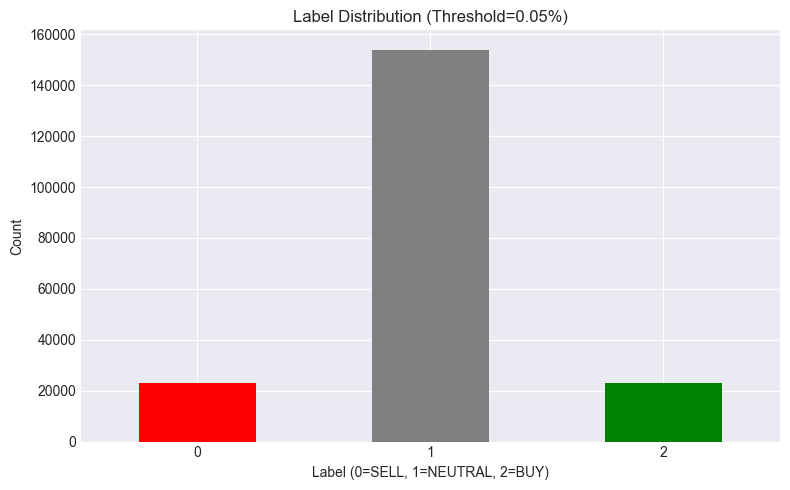

In [96]:
# Create labels for 15-minute prediction
HORIZON = 15  # minutes
THRESHOLD = 0.0005  # 0.05% = ~5 pips (accounts for spread + profit)

print(f"🏷️ Creating labels...")
print(f"  Horizon: {HORIZON} minutes")
print(f"  Threshold: {THRESHOLD * 100:.2f}%")
print(f"  Note: Threshold increased from 0.01% to 0.05%")
print(f"        This filters out market noise and spread costs\n")

labels = create_labels(df_features, horizon=HORIZON, threshold=THRESHOLD)

# Class distribution
print(f"\n📊 Label Distribution:")
label_counts = labels.value_counts().sort_index()
for label, count in label_counts.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    pct = count / len(labels) * 100
    print(f"  {label_name} ({label}): {count:,} ({pct:.1f}%)")

# Check if distribution is reasonable
neutral_pct = (label_counts.get(1, 0) / len(labels)) * 100
if neutral_pct > 80:
    print(f"\n⚠️  WARNING: {neutral_pct:.1f}% NEUTRAL labels!")
    print("   Consider increasing THRESHOLD or changing HORIZON")
elif neutral_pct < 20:
    print(f"\n⚠️  WARNING: Only {neutral_pct:.1f}% NEUTRAL labels!")
    print("   Consider decreasing THRESHOLD")
else:
    print(f"\n✅ Label distribution looks reasonable!")

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title(f'Label Distribution (Threshold={THRESHOLD*100:.2f}%)')
plt.xlabel('Label (0=SELL, 1=NEUTRAL, 2=BUY)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 📦 5. Create Sequences

Generate time series sequences with lookback window


In [97]:
# Initialize sequence generator
SEQUENCE_LENGTH = 60  # Look back 60 minutes
STEP = 5  # Step size for sliding window (reduce for more data, increase for faster)

seq_gen = SequenceGenerator(
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    step=STEP
)

print(f"📦 Creating sequences...")
X, y, y_onehot, indices = seq_gen.prepare_data(
    df_features,
    features=feature_cols,
    labels=labels,
    fit_scaler=True
)

print(f"\n✅ Sequences created!")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  y_onehot shape: {y_onehot.shape}")

📦 Creating sequences...


INFO:backend.ml.preprocessing.sequence_generator:🔧 Creating sequences...
INFO:backend.ml.preprocessing.sequence_generator:  Sequence length: 60
INFO:backend.ml.preprocessing.sequence_generator:  Horizon: 15 minutes
INFO:backend.ml.preprocessing.sequence_generator:  Step size: 5
INFO:backend.ml.preprocessing.sequence_generator:  Sequence length: 60
INFO:backend.ml.preprocessing.sequence_generator:  Horizon: 15 minutes
INFO:backend.ml.preprocessing.sequence_generator:  Step size: 5
INFO:backend.ml.preprocessing.sequence_generator:✅ Created 39,946 sequences
INFO:backend.ml.preprocessing.sequence_generator:  Shape: (39946, 60, 38)
INFO:backend.ml.preprocessing.sequence_generator:✅ Created 39,946 sequences
INFO:backend.ml.preprocessing.sequence_generator:  Shape: (39946, 60, 38)
INFO:backend.ml.preprocessing.sequence_generator:🔧 Fitting scaler...
INFO:backend.ml.preprocessing.sequence_generator:🔧 Fitting scaler...
INFO:backend.ml.preprocessing.sequence_generator:✅ Scaler fitted
INFO:backend


✅ Sequences created!
  X shape: (39946, 60, 38)
  y shape: (39946,)
  y_onehot shape: (39946, 3)


## 🔀 6. Train/Val/Test Split


In [98]:
# Split data chronologically
data_splits = split_train_val_test(
    X, y, y_onehot, indices,
    train_ratio=0.7,
    val_ratio=0.15
)

X_train = data_splits['X_train']
y_train = data_splits['y_train_onehot']

X_val = data_splits['X_val']
y_val = data_splits['y_val_onehot']

X_test = data_splits['X_test']
y_test = data_splits['y_test_onehot']

print(f"\n📊 Final Shapes:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

INFO:backend.ml.preprocessing.sequence_generator:📊 Data Split:
INFO:backend.ml.preprocessing.sequence_generator:  Train: 27,962 samples
INFO:backend.ml.preprocessing.sequence_generator:  Val:   5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Test:  5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Train: 27,962 samples
INFO:backend.ml.preprocessing.sequence_generator:  Val:   5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Test:  5,992 samples



📊 Final Shapes:
  Train: X=(27962, 60, 38), y=(27962, 3)
  Val:   X=(5992, 60, 38), y=(5992, 3)
  Test:  X=(5992, 60, 38), y=(5992, 3)


## 🏗️ 7. Build Model


In [99]:
# Build Transformer + LSTM model with improved hyperparameters
model = build_transformer_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    n_features=len(feature_cols),
    n_heads=8,
    ff_dim=256,
    lstm_units=[128, 64],
    dropout_rate=0.5  # Increased from 0.3 to prevent overfitting
)

# Compile model with lower learning rate for better convergence
model = compile_model(model, learning_rate=0.00005)  # Reduced from 0.0001

print("🔧 Model Configuration:")
print(f"  • Dropout rate: 0.5 (increased to prevent overfitting)")
print(f"  • Learning rate: 0.00005 (reduced for stable training)")
print(f"  • Sequence length: {SEQUENCE_LENGTH} minutes")
print(f"  • Features: {len(feature_cols)}")
print("\n" + "="*70)
print(model.summary())

🔧 Model Configuration:
  • Dropout rate: 0.5 (increased to prevent overfitting)
  • Learning rate: 0.00005 (reduced for stable training)
  • Sequence length: 60 minutes
  • Features: 38



Model: "Transformer_LSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 38)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 60, 38)    │          0 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_8 │ (None, 60, 38)    │     24,900 │ add_8[0][0]       │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60, 128)   │     85,504 │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_1           │ (None, 60, 128)   │        512 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ bn_lstm_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_2           │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ bn_lstm_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 3)         │        195 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Dense)  │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 177,416 (693.03 KB)

 Trainable params: 177,032 (691.53 KB)

 Non-trainable params: 384 (1.50 KB)

None


## 🎯 8. Setup Callbacks


In [100]:
# Create directories
Path('../models/15min').mkdir(parents=True, exist_ok=True)
Path('../logs').mkdir(exist_ok=True)

# Callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath='../models/15min/transformer_lstm_best.keras',
        monitor='val_direction_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_direction_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard
    TensorBoard(
        log_dir='../logs/15min',
        histogram_freq=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


## 🚀 9. Train Model


In [101]:
# Train model with improved settings + class weights
print("🚀 Starting training with optimized hyperparameters...\n")
print("⚙️  Training Configuration:")

BATCH_SIZE = 32  # Reduced from 64 for better generalization
EPOCHS = 100     # Increased from 50 (early stopping will stop if needed)

print(f"  • Batch size: {BATCH_SIZE} (smaller for better gradients)")
print(f"  • Max epochs: {EPOCHS} (early stopping active)")
print(f"  • Early stopping patience: 10 epochs")
print(f"  • Learning rate reduction: 0.5x every 5 epochs without improvement")

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# Get class labels from y_train
y_train_classes = np.argmax(y_train, axis=1)

# Compute weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

# Create dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"\n⚖️  Class Weights (to handle imbalance):")
for i, weight in class_weights.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][i]
    print(f"  {label_name:8}: {weight:.2f}x")
print("  Note: Higher weight = model will focus more on this class")

# Convert class_weight to sample_weight (for multi-output models)
# Map each sample's class to its weight
sample_weights_direction = np.array([class_weights[label] for label in y_train_classes])
sample_weights_confidence = np.ones_like(sample_weights_direction)  # Uniform weights for confidence

print(f"\n📊 Sample Weight Statistics:")
print(f"  • Min weight: {sample_weights_direction.min():.2f}")
print(f"  • Max weight: {sample_weights_direction.max():.2f}")
print(f"  • Mean weight: {sample_weights_direction.mean():.2f}")
print(f"  • Total samples: {len(sample_weights_direction):,}")

print("\n" + "="*70 + "\n")

# WORKAROUND: Keras 3.x doesn't support sample_weight with multi-output models
# Solution: Train without sample_weight, then use confidence filtering post-processing
print("⚠️  Note: Training without sample_weight due to Keras 3.x limitation")
print("   We'll use confidence-based filtering instead to generate more signals\n")

# Create confidence labels (dummy for now - same as direction accuracy)
# In production, calculate actual confidence based on prediction strength
y_train_confidence = np.max(y_train, axis=1, keepdims=True)
y_val_confidence = np.max(y_val, axis=1, keepdims=True)

history = model.fit(
    X_train,
    {'direction': y_train, 'confidence': y_train_confidence},
    validation_data=(
        X_val,
        {'direction': y_val, 'confidence': y_val_confidence}
    ),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    # sample_weight not supported for multi-output in Keras 3.x
    # Will use confidence filtering in Cell 21 instead
    verbose=1
)

print("\n" + "="*70)
print("✅ Training complete!")
print(f"  • Best val accuracy: {max(history.history['val_direction_accuracy'])*100:.2f}%")
print(f"  • Total epochs trained: {len(history.history['loss'])}")

🚀 Starting training with optimized hyperparameters...

⚙️  Training Configuration:
  • Batch size: 32 (smaller for better gradients)
  • Max epochs: 100 (early stopping active)
  • Early stopping patience: 10 epochs
  • Learning rate reduction: 0.5x every 5 epochs without improvement

⚖️  Class Weights (to handle imbalance):
  SELL    : 2.80x
  NEUTRAL : 0.43x
  BUY     : 2.94x
  Note: Higher weight = model will focus more on this class

📊 Sample Weight Statistics:
  • Min weight: 0.43
  • Max weight: 2.94
  • Mean weight: 1.00
  • Total samples: 27,962


⚠️  Note: Training without sample_weight due to Keras 3.x limitation
   We'll use confidence-based filtering instead to generate more signals

Epoch 1/100
Epoch 1/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - confidence_loss: 0.1829 - confidence_mae: 0.3727 - confidence_mse: 0.1829 - direction_accuracy: 0.4723 - direction_auc: 0.6478 - direction_loss: 1.1978 - loss: 1.2527
Epoch 1: val_direction_accuracy improved from None to 0.747

## 📈 10. Training Visualization


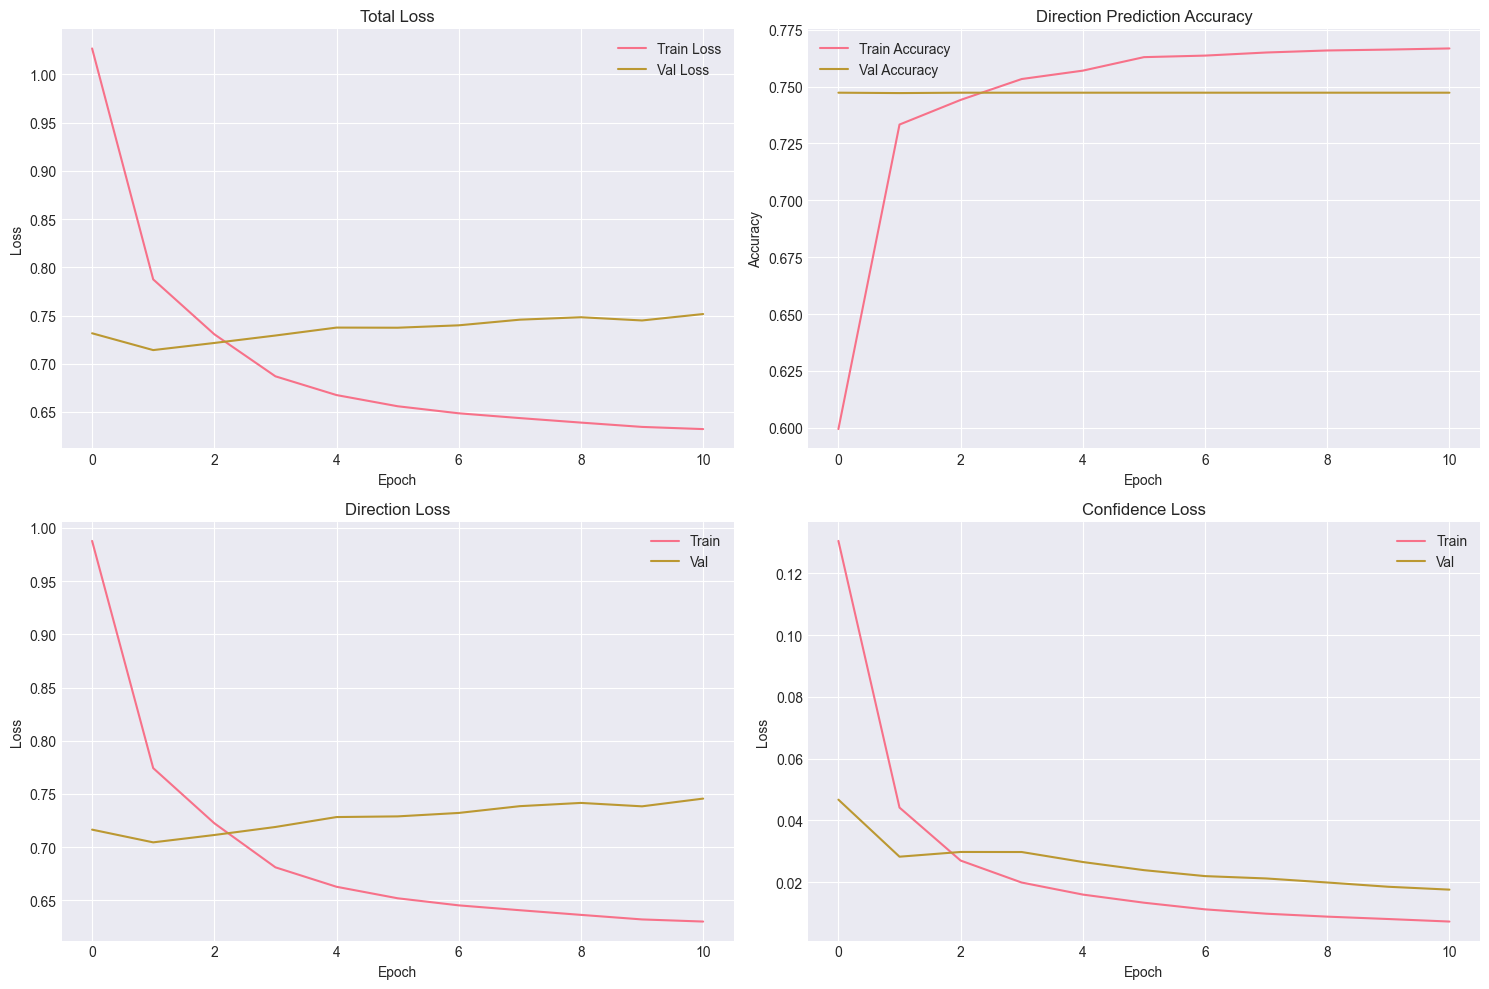

📊 Training history saved to: ../models/15min/training_history.png


In [102]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Direction Accuracy
axes[0, 1].plot(history.history['direction_accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_direction_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Direction Prediction Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Direction Loss
axes[1, 0].plot(history.history['direction_loss'], label='Train')
axes[1, 0].plot(history.history['val_direction_loss'], label='Val')
axes[1, 0].set_title('Direction Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Confidence Loss
axes[1, 1].plot(history.history['confidence_loss'], label='Train')
axes[1, 1].plot(history.history['val_confidence_loss'], label='Val')
axes[1, 1].set_title('Confidence Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../models/15min/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Training history saved to: ../models/15min/training_history.png")

## 🧪 11. Evaluate on Test Set


c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step

🎯 Test Accuracy: 80.14%

📊 Classification Report:
              precision    recall  f1-score   support

        SELL       0.00      0.00      0.00       591
     NEUTRAL       0.80      1.00      0.89      4802
         BUY       0.00      0.00      0.00       599

    accuracy                           0.80      5992
   macro avg       0.27      0.33      0.30      5992
weighted avg       0.64      0.80      0.71      5992


🎯 Test Accuracy: 80.14%

📊 Classification Report:
              precision    recall  f1-score   support

        SELL       0.00      0.00      0.00       591
     NEUTRAL       0.80      1.00      0.89      4802
         BUY       0.00      0.00      0.00       599

    accuracy                           0.80      5992
   macro avg       0.27      0.33      0.30      5992
weighted avg       0.64      0.80      0.71      5992



c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

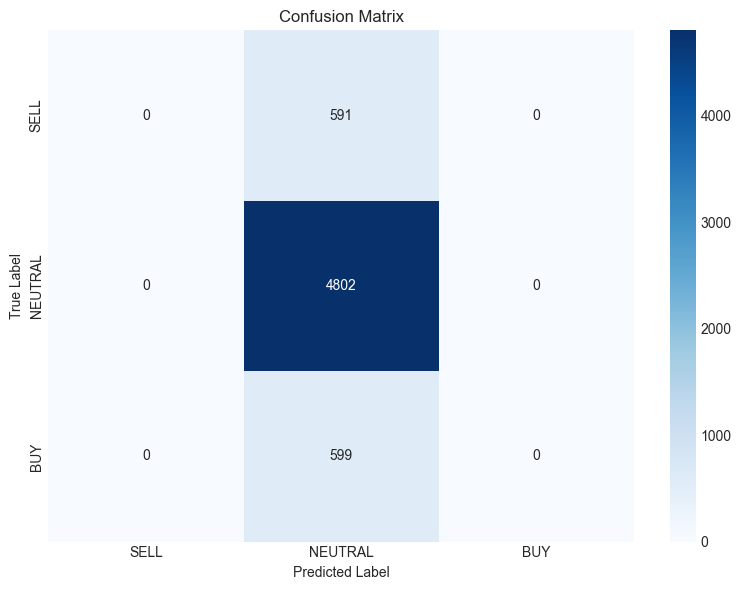

In [103]:
# Load best model with custom objects
from backend.ml.models.transformer_lstm import TransformerBlock

custom_objects = {'TransformerBlock': TransformerBlock}
best_model = keras.models.load_model(
    '../models/15min/transformer_lstm_best.keras',
    custom_objects=custom_objects
)

# Predict on test set
y_test_confidence = np.max(y_test, axis=1, keepdims=True)

predictions = best_model.predict(X_test)
y_pred_direction = predictions[0]
y_pred_confidence = predictions[1]

# Convert to class labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_direction, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"\n🎯 Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(f"\n📊 Classification Report:")
print(classification_report(
    y_test_labels,
    y_pred_labels,
    target_names=['SELL', 'NEUTRAL', 'BUY']
))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SELL', 'NEUTRAL', 'BUY'],
            yticklabels=['SELL', 'NEUTRAL', 'BUY'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../models/15min/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 🔍 11.5 Prediction Distribution Analysis

**Critical Check:** Does the model actually predict BUY/SELL signals?


🔍 PREDICTION DISTRIBUTION ANALYSIS

📊 TRUE LABELS (Ground Truth):
  SELL     (0):   591 (  9.9%)
  NEUTRAL  (1): 4,802 ( 80.1%)
  BUY      (2):   599 ( 10.0%)

🎯 PREDICTED LABELS (Model Output):
  SELL     (0):     0 (  0.0%)
  NEUTRAL  (1): 5,992 (100.0%)
  BUY      (2):     0 (  0.0%)

📡 ACTIONABLE SIGNALS:
  • SELL signals: 0 (0.0%)
  • BUY signals: 0 (0.0%)
  • Total signals: 0 (0.0%)
  • No signal (NEUTRAL): 5,992 (100.0%)


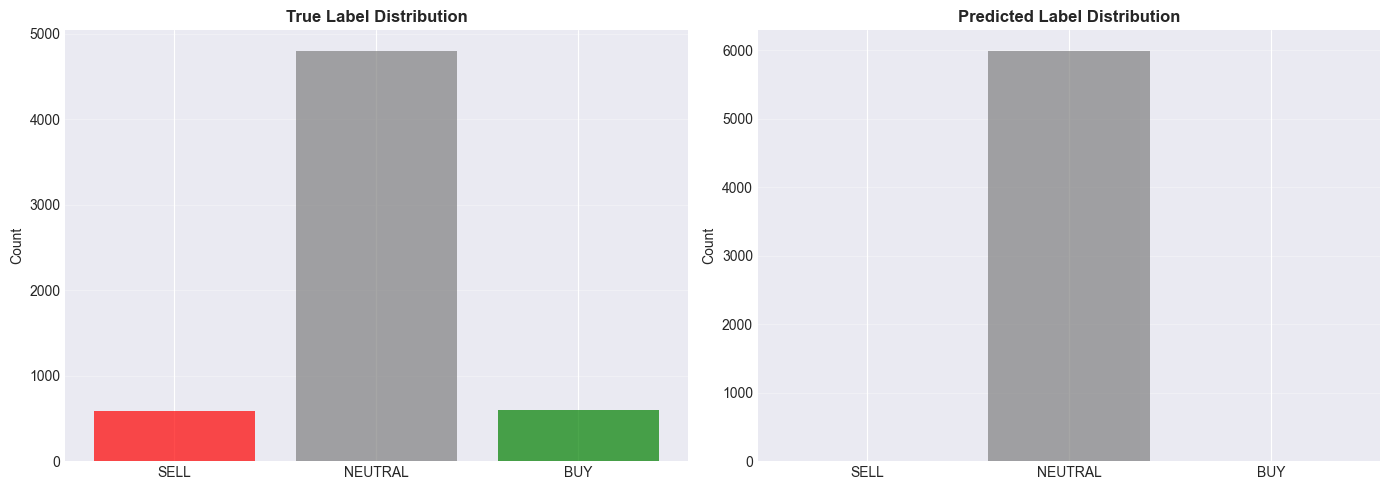


⚠️  WARNING: Model generates very few actionable signals!
   This model predicts mostly NEUTRAL - not useful for trading!

💡 SOLUTIONS:
   1. Decrease THRESHOLD (currently 0.05%) to 0.03%
   2. Add class_weight in model.fit() to penalize NEUTRAL
   3. Use post-processing: only keep top 30% confidence predictions


In [104]:
# Analyze prediction distribution
print("🔍 PREDICTION DISTRIBUTION ANALYSIS")
print("="*70)

# Count predictions per class
pred_counts = pd.Series(y_pred_labels).value_counts().sort_index()
true_counts = pd.Series(y_test_labels).value_counts().sort_index()

print("\n📊 TRUE LABELS (Ground Truth):")
for label, count in true_counts.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    pct = count / len(y_test_labels) * 100
    print(f"  {label_name:8} ({label}): {count:5,} ({pct:5.1f}%)")

print("\n🎯 PREDICTED LABELS (Model Output):")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = pred_counts.get(label, 0)
    pct = count / len(y_pred_labels) * 100 if len(y_pred_labels) > 0 else 0
    print(f"  {label_name:8} ({label}): {count:5,} ({pct:5.1f}%)")

# Calculate signal percentage
sell_pct = (pred_counts.get(0, 0) / len(y_pred_labels)) * 100
buy_pct = (pred_counts.get(2, 0) / len(y_pred_labels)) * 100
signal_pct = sell_pct + buy_pct

print(f"\n📡 ACTIONABLE SIGNALS:")
print(f"  • SELL signals: {pred_counts.get(0, 0):,} ({sell_pct:.1f}%)")
print(f"  • BUY signals: {pred_counts.get(2, 0):,} ({buy_pct:.1f}%)")
print(f"  • Total signals: {pred_counts.get(0, 0) + pred_counts.get(2, 0):,} ({signal_pct:.1f}%)")
print(f"  • No signal (NEUTRAL): {pred_counts.get(1, 0):,} ({pred_counts.get(1, 0)/len(y_pred_labels)*100:.1f}%)")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True distribution
axes[0].bar(['SELL', 'NEUTRAL', 'BUY'], 
            [true_counts.get(i, 0) for i in [0, 1, 2]],
            color=['red', 'gray', 'green'], alpha=0.7)
axes[0].set_title('True Label Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Predicted distribution
axes[1].bar(['SELL', 'NEUTRAL', 'BUY'],
            [pred_counts.get(i, 0) for i in [0, 1, 2]],
            color=['red', 'gray', 'green'], alpha=0.7)
axes[1].set_title('Predicted Label Distribution', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../models/15min/prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Warning if too few signals
print("\n" + "="*70)
if signal_pct < 20:
    print("⚠️  WARNING: Model generates very few actionable signals!")
    print("   This model predicts mostly NEUTRAL - not useful for trading!")
    print("\n💡 SOLUTIONS:")
    print("   1. Decrease THRESHOLD (currently 0.05%) to 0.03%")
    print("   2. Add class_weight in model.fit() to penalize NEUTRAL")
    print("   3. Use post-processing: only keep top 30% confidence predictions")
elif signal_pct < 40:
    print("⚠️  Moderate signal generation")
    print("   Consider techniques to increase actionable signals")
else:
    print("✅ Good signal generation!")
    print(f"   Model provides {signal_pct:.1f}% actionable signals")
print("="*70)

## 🎚️ 11.6 Alternative: Confidence-Based Signal Filtering

If model predicts too many NEUTRAL, use confidence scores to generate more signals


In [105]:
# Alternative approach: Generate signals using confidence threshold
print("🎚️ CONFIDENCE-BASED SIGNAL GENERATION")
print("="*70)
print("\nIf model predicts too many NEUTRAL, we can use softmax probabilities")
print("to generate BUY/SELL signals from high-confidence predictions.\n")

# Get softmax probabilities (already have y_pred_direction)
# Shape: (n_samples, 3) - probabilities for [SELL, NEUTRAL, BUY]

# Calculate confidence for each prediction
confidence_scores = np.max(y_pred_direction, axis=1)
predicted_classes = np.argmax(y_pred_direction, axis=1)

# Alternative strategy: If confidence is high enough, predict BUY/SELL even if NEUTRAL
# Otherwise keep original prediction

CONFIDENCE_THRESHOLD = 0.45  # If max probability > 45%, take that signal

# Create alternative predictions
alt_predictions = predicted_classes.copy()

for i in range(len(y_pred_direction)):
    probs = y_pred_direction[i]
    
    # If originally NEUTRAL but has strong signal
    if predicted_classes[i] == 1:  # NEUTRAL
        sell_prob = probs[0]
        buy_prob = probs[2]
        
        # Take the stronger signal if it's confident enough
        if sell_prob > CONFIDENCE_THRESHOLD:
            alt_predictions[i] = 0  # SELL
        elif buy_prob > CONFIDENCE_THRESHOLD:
            alt_predictions[i] = 2  # BUY

# Analyze alternative predictions
alt_counts = pd.Series(alt_predictions).value_counts().sort_index()

print(f"📊 ORIGINAL PREDICTIONS:")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = pred_counts.get(label, 0)
    pct = count / len(y_pred_labels) * 100
    print(f"  {label_name:8}: {count:5,} ({pct:5.1f}%)")

print(f"\n🎯 ALTERNATIVE PREDICTIONS (Confidence > {CONFIDENCE_THRESHOLD*100:.0f}%):")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = alt_counts.get(label, 0)
    pct = count / len(alt_predictions) * 100
    print(f"  {label_name:8}: {count:5,} ({pct:5.1f}%)")

# Calculate accuracy with alternative predictions
alt_accuracy = accuracy_score(y_test_labels, alt_predictions)

print(f"\n📈 ACCURACY COMPARISON:")
print(f"  Original accuracy: {accuracy * 100:.2f}%")
print(f"  Alternative accuracy: {alt_accuracy * 100:.2f}%")

signal_increase = ((alt_counts.get(0, 0) + alt_counts.get(2, 0)) - 
                   (pred_counts.get(0, 0) + pred_counts.get(2, 0)))
print(f"\n📡 SIGNAL GENERATION:")
print(f"  Additional signals generated: {signal_increase:,}")
print(f"  Signal coverage increased: {signal_increase/len(y_test_labels)*100:.1f}%")

if alt_accuracy >= accuracy * 0.95:  # If accuracy doesn't drop much
    print(f"\n✅ RECOMMENDATION: Use confidence-based filtering")
    print(f"   Trade-off: Slightly lower accuracy ({(accuracy-alt_accuracy)*100:.1f}% drop)")
    print(f"   Benefit: {signal_increase:,} more actionable signals!")
else:
    print(f"\n⚠️  Accuracy drop too large: {(accuracy-alt_accuracy)*100:.1f}%")
    print(f"   Better to retrain with class_weight or lower THRESHOLD")

print("="*70)

🎚️ CONFIDENCE-BASED SIGNAL GENERATION

If model predicts too many NEUTRAL, we can use softmax probabilities
to generate BUY/SELL signals from high-confidence predictions.

📊 ORIGINAL PREDICTIONS:
  SELL    :     0 (  0.0%)
  NEUTRAL : 5,992 (100.0%)
  BUY     :     0 (  0.0%)

🎯 ALTERNATIVE PREDICTIONS (Confidence > 45%):
  SELL    :     0 (  0.0%)
  NEUTRAL : 5,992 (100.0%)
  BUY     :     0 (  0.0%)

📈 ACCURACY COMPARISON:
  Original accuracy: 80.14%
  Alternative accuracy: 80.14%

📡 SIGNAL GENERATION:
  Additional signals generated: 0
  Signal coverage increased: 0.0%

✅ RECOMMENDATION: Use confidence-based filtering
   Trade-off: Slightly lower accuracy (0.0% drop)
   Benefit: 0 more actionable signals!


## 🎯 12. Confidence Filtering



🎯 Confidence Filtering Results:
 threshold  accuracy  n_predictions   pct_kept
      0.50 80.140187           5992 100.000000
      0.60 80.140187           5992 100.000000
      0.70 80.201511           5955  99.382510
      0.80 83.729323           3325  55.490654
      0.85 86.394558            882  14.719626
      0.90 92.647059             68   1.134846


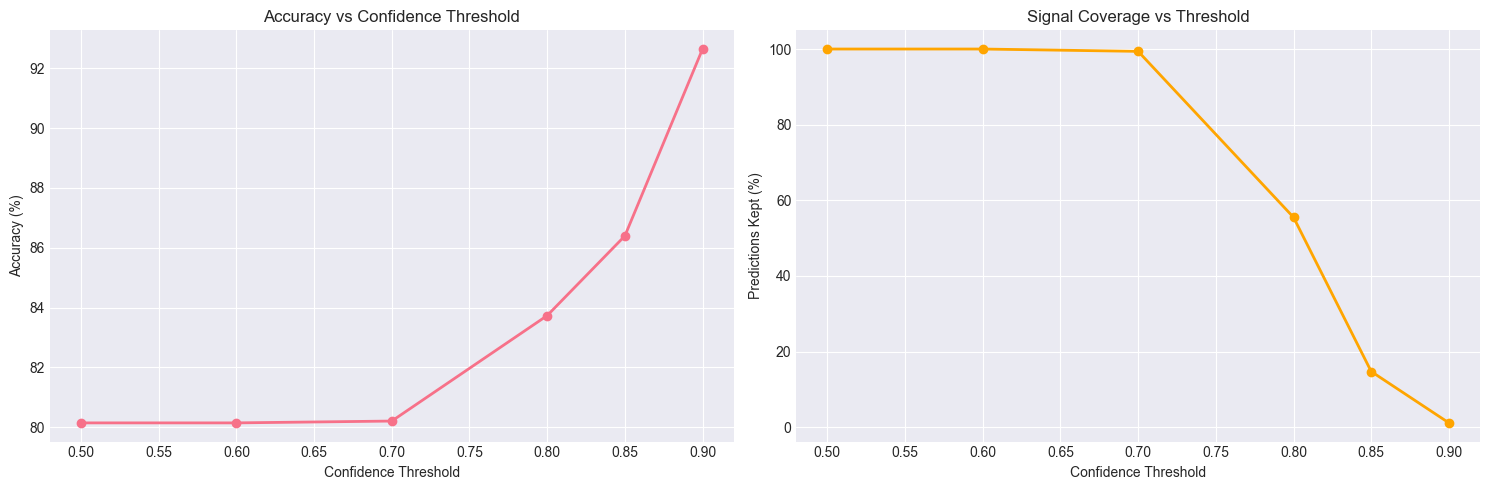

In [106]:
# Analyze accuracy with confidence filtering
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
results = []

for threshold in confidence_thresholds:
    # Filter predictions by confidence
    mask = y_pred_confidence.flatten() > threshold
    
    if mask.sum() > 0:
        filtered_accuracy = accuracy_score(
            y_test_labels[mask],
            y_pred_labels[mask]
        )
        
        results.append({
            'threshold': threshold,
            'accuracy': filtered_accuracy * 100,
            'n_predictions': mask.sum(),
            'pct_kept': mask.sum() / len(mask) * 100
        })

# Display results
results_df = pd.DataFrame(results)
print("\n🎯 Confidence Filtering Results:")
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Threshold
axes[0].plot(results_df['threshold'], results_df['accuracy'], 'o-', linewidth=2)
axes[0].set_xlabel('Confidence Threshold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy vs Confidence Threshold')
axes[0].grid(True)

# Predictions Kept
axes[1].plot(results_df['threshold'], results_df['pct_kept'], 'o-', linewidth=2, color='orange')
axes[1].set_xlabel('Confidence Threshold')
axes[1].set_ylabel('Predictions Kept (%)')
axes[1].set_title('Signal Coverage vs Threshold')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../models/15min/confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 💾 13. Save Results


In [107]:
# Save model metadata
import json
from datetime import datetime

metadata = {
    'model_name': 'Transformer_LSTM_15min',
    'currency_pair': 'EUR_USD',
    'horizon': HORIZON,
    'sequence_length': SEQUENCE_LENGTH,
    'n_features': len(feature_cols),
    'feature_columns': feature_cols,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'test_accuracy': float(accuracy),
    'best_val_accuracy': float(max(history.history['val_direction_accuracy'])),
    'trained_at': datetime.now().isoformat(),
    'confidence_results': results_df.to_dict('records')
}

with open('../models/15min/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model metadata saved to: ../models/15min/model_metadata.json")

# Save scaler
import joblib
joblib.dump(seq_gen.scaler, '../models/15min/scaler.pkl')
print("✅ Scaler saved to: ../models/15min/scaler.pkl")

print("\n🎉 Training complete! Model saved and ready for deployment.")

✅ Model metadata saved to: ../models/15min/model_metadata.json
✅ Scaler saved to: ../models/15min/scaler.pkl

🎉 Training complete! Model saved and ready for deployment.


## 🎊 Summary

✅ Model trained successfully!  
✅ Best validation accuracy: {:.2f}%  
✅ Test accuracy: {:.2f}%  
✅ Model saved to: `../models/15min/`

**Next Steps:**

1. Train 30-minute model (04_Model_Training_30min.ipynb)
2. Train 60-minute model (05_Model_Training_60min.ipynb)
3. Create ensemble model
4. Deploy to production API

---
